# Face Recognition Project

## 1. Import dataset: Full **Pinterest Dataset**

In [1]:
# pins_face
!gdown 1o2TkrzwObdbmlAOHdD-h8AegGi4jcYTw

Downloading...
From: https://drive.google.com/uc?id=1o2TkrzwObdbmlAOHdD-h8AegGi4jcYTw
To: /content/pins_face.zip
100% 390M/390M [00:09<00:00, 42.4MB/s]


In [3]:
import zipfile
import os
with zipfile.ZipFile('pins_face.zip', 'r') as zip_ref:
    zip_ref.extractall(os.getcwd())

## 2. Preparing training and validation set

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models, applications

In [4]:
img_dir = os.path.join(os.getcwd(), '105_classes_pins_dataset')

In [5]:
batch_size = 64
target_shape = (160, 160)

In [6]:
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
  img_dir,
  validation_split=0.2,
  seed=370,
  subset="both",
  image_size=target_shape,
  batch_size=batch_size)

Found 17534 files belonging to 105 classes.
Using 14028 files for training.
Using 3506 files for validation.


In [7]:
class_names = train_ds.class_names
class_names = [name.split('_')[1].lower() for name in class_names]
class_names

['adriana lima',
 'alex lawther',
 'alexandra daddario',
 'alvaro morte',
 'amanda crew',
 'andy samberg',
 'anne hathaway',
 'anthony mackie',
 'avril lavigne',
 'ben affleck',
 'bill gates',
 'bobby morley',
 'brenton thwaites',
 'brian j. smith',
 'brie larson',
 'chris evans',
 'chris hemsworth',
 'chris pratt',
 'christian bale',
 'cristiano ronaldo',
 'danielle panabaker',
 'dominic purcell',
 'dwayne johnson',
 'eliza taylor',
 'elizabeth lail',
 'emilia clarke',
 'emma stone',
 'emma watson',
 'gwyneth paltrow',
 'henry cavil',
 'hugh jackman',
 'inbar lavi',
 'irina shayk',
 'jake mcdorman',
 'jason momoa',
 'jennifer lawrence',
 'jeremy renner',
 'jessica barden',
 'jimmy fallon',
 'johnny depp',
 'josh radnor',
 'katharine mcphee',
 'katherine langford',
 'keanu reeves',
 'krysten ritter',
 'leonardo dicaprio',
 'lili reinhart',
 'lindsey morgan',
 'lionel messi',
 'logan lerman',
 'madelaine petsch',
 'maisie williams',
 'maria pedraza',
 'marie avgeropoulos',
 'mark ruffal

## 3. Building model with **FaceNet** as base model

### Data augmentation

In [8]:
class RandomColorDistortion(tf.keras.layers.Layer):
  def __init__(self, contrast_range=[0.75, 1.25],
               brightness_delta=[-0.1, 0.1], **kwargs):
    super(RandomColorDistortion, self).__init__(**kwargs)
    self.contrast_range = contrast_range
    self.brightness_delta = brightness_delta

  def call(self, images, training=False):
    if not training:
      return images
    contrast = np.random.uniform(
    self.contrast_range[0], self.contrast_range[1])
    brightness = np.random.uniform(
    self.brightness_delta[0], self.brightness_delta[1])



    images = tf.image.adjust_contrast(images, contrast)
    images = tf.image.adjust_brightness(images, brightness)
    images = tf.clip_by_value(images, 0, 255)
    return images

In [9]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  #tf.keras.layers.RandomRotation(0.1),
  RandomColorDistortion(name='random_contrast_brightness/none'),
])

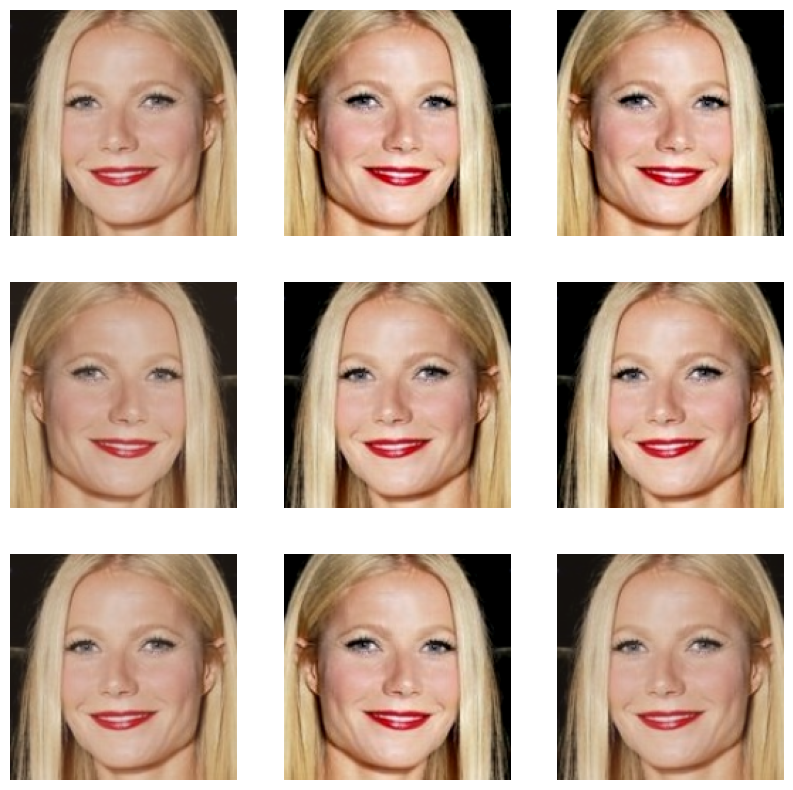

In [9]:
for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0), training=True)
    plt.imshow(augmented_image[0] / 255);
    plt.axis('off')

### Preprocessing inputs

In [10]:
# our facenet implementation architecture is Inception_resnet_v1, so we assume it uses the same preprocessing function
preprocess_input = applications.inception_resnet_v2.preprocess_input

### Base model


In [11]:
!gdown 1qeHMMoMyE9VcF-Qzyev-0rcqTQskrBzY

Downloading...
From: https://drive.google.com/uc?id=1qeHMMoMyE9VcF-Qzyev-0rcqTQskrBzY
To: /content/facenet_keras.zip
100% 85.3M/85.3M [00:02<00:00, 38.4MB/s]


In [11]:
with zipfile.ZipFile('facenet_keras.zip', 'r') as zip_ref:
    zip_ref.extractall(os.getcwd())

In [12]:
face_net = tf.keras.models.load_model('facenet_keras')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/lambda_layer.py:327: UserWarning: keras.layers.core.lambda_layer is not loaded, but a Lambda layer uses it. It may cause errors.
  function = cls._parse_function_from_config(


In [ ]:
face_net.summary()

In [15]:
#fine-tuning
trainable = False
number_of_layer=0
for layer in face_net.layers:
    number_of_layer+=1
    if layer.name == "Block8_6_Conv2d_1x1":
        trainable = True
    layer.trainable = trainable

### Model output

In [13]:
softmax = layers.Dense(len(train_ds.class_names),
                       activation=tf.keras.activations.softmax)

### Assemble layers

In [14]:

inputs = tf.keras.Input(shape=target_shape + (3,))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = face_net(x)
#x = global_average_layer(x)
#x = layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = softmax(x)
model = tf.keras.Model(inputs, outputs)





In [23]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 160, 160, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 160, 160, 3)       0         
 da)                                                             
                                                                 
 inception_resnet_v1 (Funct  (None, 128)               22808144  
 ional)                                                          
                                                             

### Choosing optimizers

In [15]:
optimizer =  tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

### Create callbacks to stop training when target goal is reached

In [ ]:
class CustomCallback(tf.keras.callbacks.Callback):


    #def on_epoch_begin(self, epoch, logs=None):
        #print('\n')
        #print("Start epoch {} of training\n".format(epoch))

    def on_epoch_end(self, epoch, logs=None):
        val_acc = logs['val_accuracy']
        acc = logs['accuracy']
        if val_acc >= 0.97 and np.abs(val_acc-acc)<=0.01:
            self.model.stop_training = True
            print("goal reached\n")

### You can skip the following cells and use my trained weights, otherwise go ahead

In [ ]:
epochs=30
customCallback = CustomCallback()
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[customCallback]
)

In [ ]:
# saving the training result as csv file if you wish
import pandas as pd

pd.DataFrame(history.history).to_csv('facenet_dropout_pins.csv')

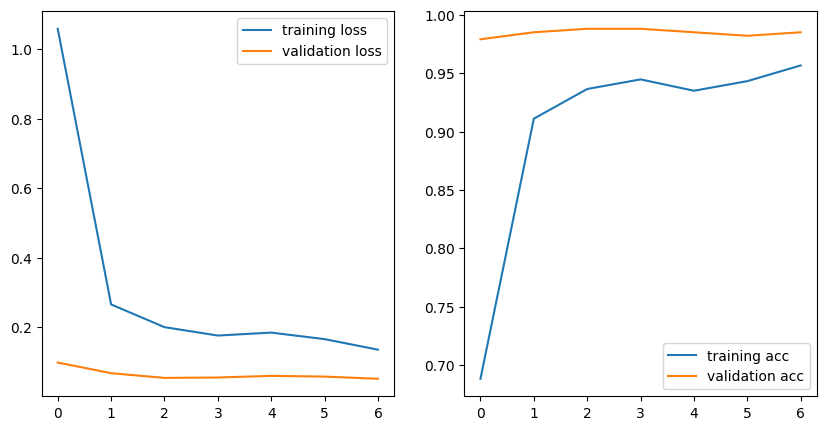

In [ ]:
# visualize training result
import matplotlib.pyplot as plt
%matplotlib inline

training_loss, training_acc = history.history['loss'], history.history['accuracy']
val_loss, val_acc = history.history['val_loss'], history.history['val_accuracy']

fig, ax = plt.subplots(1,2, figsize=(10, 5))
ax[0].plot(training_loss, label='training loss')
ax[0].plot(val_loss, label='validation loss')
ax[0].legend()

ax[1].plot(training_acc, label='training acc')
ax[1].plot(val_acc, label='validation acc')
ax[1].legend()

In [ ]:
# we chose to save weights, because we needed to access facenet intermediate layer for Grad-CAM
# but you can save model for the ease of inference
model.save('facenet_norotation_pins')

In [ ]:
!tar -czvf facenet_pins_val_96.tar facenet_norotation_pins/

### download the pretrained weights below

In [18]:
!gdown 1fnJ6_LR7gJdE94xarfkZLYiyGtRjuOSh

Downloading...
From: https://drive.google.com/uc?id=1fnJ6_LR7gJdE94xarfkZLYiyGtRjuOSh
To: /content/weights_facenet_val_96.tar
100% 91.4M/91.4M [00:02<00:00, 40.7MB/s]


In [19]:
!tar -xf weights_facenet_val_96.tar

In [16]:
model.load_weights('./facenet_keras_norotation/val_acc_0.96')

In [67]:
model.evaluate(train_ds) # remember to compile the model first

220/220 [==============================] - 22s 86ms/step - loss: 0.1504 - accuracy: 0.9751


[0.1504288613796234, 0.9751212000846863]

In [21]:
model.evaluate(val_ds)

55/55 [==============================] - 141s 3s/step - loss: 0.1419 - accuracy: 0.9778


[0.14185810089111328, 0.9777524471282959]

# **MTCNN** and **Grad-CAM**

## **MTCNN**

In [17]:
!pip install mtcnn # install module mtcnn for face cropping

In [18]:
from mtcnn import MTCNN

detector = MTCNN() # create an instanec of MTCNN

### some helper function for visualization and batch predictions

In [19]:
def draw_facebox(img, result_list):
  """
  function to draw dectected faces on an image
  """
  plt.figure(figsize=(10,10))
  plt.imshow(img)
  ax = plt.gca()
  for result in result_list:
    x, y, width, height = result
    rect = plt.Rectangle((x, y), width, height, fill=False, color='green', linewidth=2)
    ax.add_patch(rect)
  plt.show()

In [20]:
def adjust_cropped_faces(img_array, bbox, scale=0.1):
  '''
  function to 'extend' the width and height of cropped faces by 20*scale percent
  '''
  x, y , width, height = bbox
  max_height, max_width = img_array.shape[:2]
  tl_y = max(y-int(scale *height), 0)
  br_y = min(y+height+int(scale *height), max_height)
  tl_x = max(x-int(scale *width), 0)
  br_x = min(x+width+int(scale *width), max_width)

  return img_array[tl_y:br_y, tl_x:br_x,:]

In [21]:
def predict_and_suppress(model, img_batch,  threshold = 0.4):
  """
  function does 2 things
  1. predict on batch of images
  2. suppress predictions with confidence score less than threshold
  return a tuple: (suppressed_images, suppressed_classes, suppressed_scores)
  """
  identity_arrays = tf.convert_to_tensor(list(map(lambda x: tf.image.resize(x, size=(160,160)), img_batch)))
  probas = model.predict(identity_arrays)
  predicted_classes = np.argmax(probas, axis=1)
  scores = np.max(probas, axis=1)
  mask = tf.where(scores > threshold, True, False)
  return  identity_arrays[mask], predicted_classes[mask], scores[mask]


In [22]:
def visualize_predictions(img_batch, clases, scores, class_names):
  '''
  function for visualizing faces, with the corresponding class and confidence score
  '''
  total_img = len(clases)
  num_col = 3
  num_row = int(np.ceil(total_img/num_col))
  figsize = (num_col*3, num_row*3)

  fig, ax = plt.subplots(num_row, num_col, figsize=figsize, gridspec_kw = {'wspace':0.15, 'hspace':0.15})
  if num_row > 1:
    for i in range(num_col*num_row):
      try:
        current_img = img_batch[i]
        ax[i//num_col, i%num_col].imshow(tf.keras.utils.array_to_img(current_img))
        ax[i//num_col, i%num_col].axis('off')
        ax[i//num_col, i%num_col].set_title(f'{class_names[clases[i]]}: {100*scores[i]:0.2f}')
      except Exception:
        fig.delaxes(ax[i//num_col, i%num_col])
  else:
    for i in range(num_col):
      try:
        current_img = img_batch[i]
        ax[i].imshow(tf.keras.utils.array_to_img(current_img))
        ax[i].axis('off')
        ax[i].set_title(f'{class_names[clases[i]]}: {100*scores[i]:0.2f}')
      except Exception:
        fig.delaxes(ax[i])


### Lets play, but please upload your images first, or use our examples

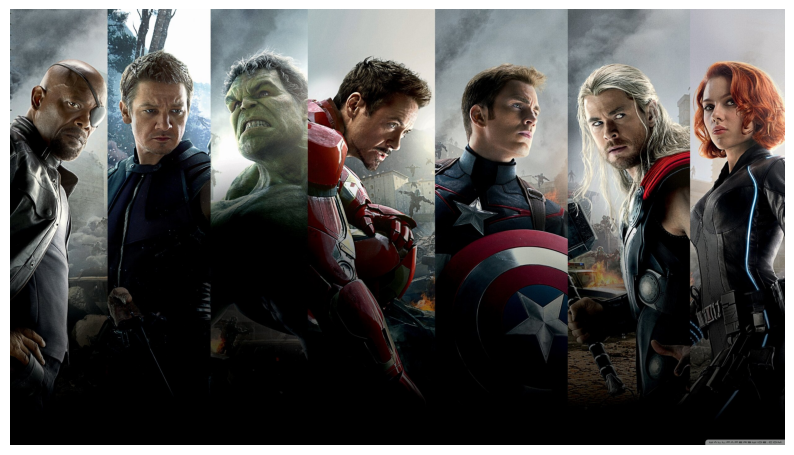

In [23]:
img = tf.keras.utils.load_img(
    'avengers.jpg'
)
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.axis('off');

In [24]:
img_array = tf.keras.utils.img_to_array(img)
faces = detector.detect_faces(img_array)
face_locations = [face['box'] for face in faces]
#print(face_locations)

3/3 [==============================] - 0s 30ms/step


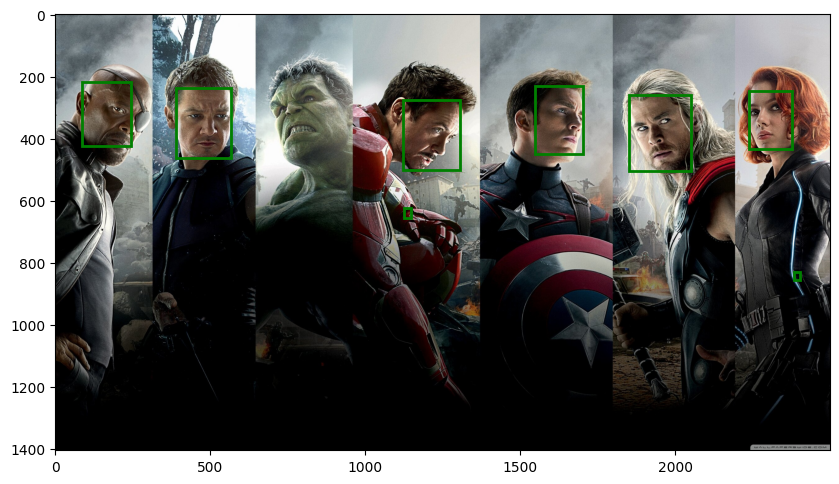

In [25]:
draw_facebox(img, face_locations) # mtcnn sometimes makes weird mistakes

In [26]:
identity_arrays = [adjust_cropped_faces(img_array, face_location)\
                   for face_location in face_locations]

In [27]:
suppressed_identities, suppressed_classes, suppressed_scores = predict_and_suppress(model, identity_arrays, threshold=0.4)

1/1 [==============================] - 6s 6s/step


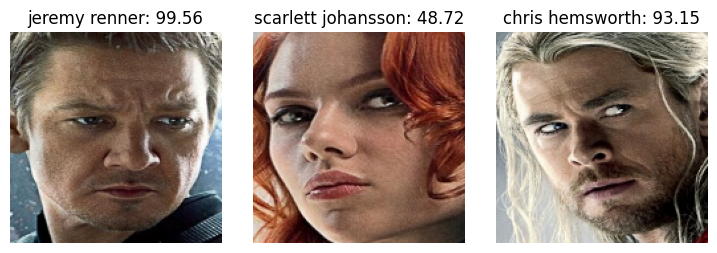

In [28]:
visualize_predictions(suppressed_identities, suppressed_classes, suppressed_scores, class_names)

For single face testing

1/1 [==============================] - 0s 234ms/step


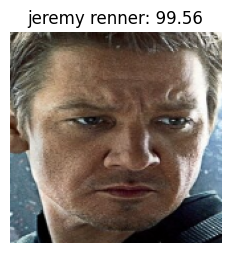

In [29]:
# for example, pick your bbox by hand from the lsit returned by MTCNN
identity_arrays = [adjust_cropped_faces(img_array, face_locations[0])]
suppressed_identities, suppressed_classes, suppressed_scores = predict_and_suppress(model, identity_arrays, threshold=0.4)
visualize_predictions(suppressed_identities, suppressed_classes, suppressed_scores, class_names)

# **Grad-CAM**

In [35]:
some_face = [adjust_cropped_faces(img_array, face_locations[4])] # Chris Hemsworth
face_array, _, _ = predict_and_suppress(model, some_face, threshold=0.0)

1/1 [==============================] - 0s 149ms/step


In [31]:
intermediate_layer = face_net.get_layer('Block8_6_Conv2d_1x1')
full_facenet = tf.keras.Model([face_net.input], [intermediate_layer.output, face_net.output])
# this is the reason why we chose to save weights instead of saving the whole model
# we need to access intermediate layer for Grad-CAM

In [36]:
def visualize_GradCAM(img_array, model, intermediate_layer):
  """
  function for visualizaing Grad-CAM
  img_array should be an image Tensor in batch, ex: (1,160,160,3)
  model here is facenet coupled with an output of intermediate layer
  intermediate_layer should be a Conv2D layer near the output of facenet, ex: a layer that produce (3,3) feature maps
  """
  with tf.GradientTape() as gtape:
      norm_img = preprocess_input(img_array)
      conv_output, embedding = model(norm_img)
      predictions = softmax(embedding)
      category_id = np.argmax(predictions)
      output = predictions[:, category_id]
      grads = gtape.gradient(output, conv_output)
      pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

  heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_output), axis=-1)
  heatmap = np.maximum(heatmap, 0)
  max_heat = np.max(heatmap)
  if max_heat == 0:
    max_heat = 1e-10
  heatmap /= max_heat
  heatmap = np.squeeze(heatmap)

  alpha = 0.4
  squeezed_img = np.squeeze(np.array(img_array))
  heatmap = cv2.resize(heatmap, (squeezed_img.shape[1], squeezed_img.shape[0]))
  heatmap = (heatmap*255).astype("uint8")
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  superimposed_img = heatmap * alpha + squeezed_img
  superimposed_img = np.clip(superimposed_img, 0, 255).astype("uint8")
  superimposed_img = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)
  return superimposed_img

(-0.5, 159.5, 159.5, -0.5)

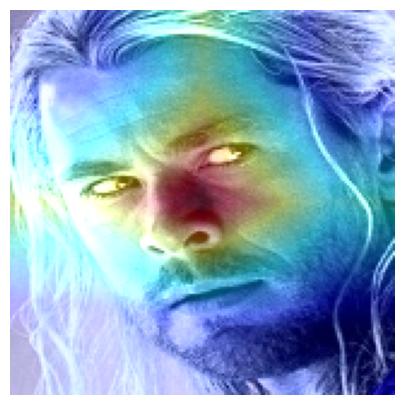

In [37]:
superimposed_img = visualize_GradCAM(face_array, model=full_facenet, intermediate_layer=intermediate_layer)
imgwithheat = PIL.Image.fromarray(superimposed_img)
fig = plt.figure(figsize= (5,5))
ax = fig.add_subplot(111)
ax.imshow(imgwithheat)
ax.axis('off')